# RSA assignment Victor Møller 

## part 1 - loading data: 

First we import the data from mne.datasets and <br/>
save it on our computer. This is ~6GB so don't run it. <br/>
We will loosely follow: <br/>
https://mne.tools/dev/auto_examples/decoding/decoding_rsa.html#sphx-glr-auto-examples-decoding-decoding-rsa-py <br/>
in this first part of the assignment.

In [1]:
## don't run:
import mne
from mne.datasets import visual_92_categories
data_path = visual_92_categories.data_path()

Using default location ~/mne_data for visual_92_categories...



Verifying hash 74f50bbeb65740903eadc229c9fa759f.



Verifying hash 203410a98afc9df9ae8ba9f933370e20.
Decompressing the archive: C:\Users\95\mne_data\MNE-visual_92_categories-data-part1.tar.gz
(please be patient, this can take some time)
Decompressing the archive: C:\Users\95\mne_data\MNE-visual_92_categories-data-part2.tar.gz
(please be patient, this can take some time)
Successfully extracted to: ['C:\\Users\\95\\mne_data\\MNE-visual_92_categories-data', 'C:\\Users\\95\\mne_data\\MNE-visual_92_categories-data']
Attempting to create new mne-python configuration file:
C:\Users\95\.mne\mne-python.json


## importing packages & tools 

Explanation for usage in comments. 

In [2]:
import os.path as op ## needed to paste variables together with strings (to get strings for data-paths). 
import numpy as np ## numpy needed in several places for working with arrays. 
from pandas import read_csv ## needed to read the data that we have stored. 
import matplotlib.pyplot as plt ## pyplot needed for plotting later. 
from mne.io import read_raw_fif, concatenate_raws ## reading certaing file-types. 



## Reading data 

Reading the meta-data (stimuli-trigger mapping) data from csv & <br/>
restricting the number of conditions for computational feasibility. 

In [15]:
## reading data. 
fname = op.join(data_path, 'visual_stimuli.csv') ## path & file concatenated to one string. 
conds = read_csv(fname) ## read the csv. 
print(conds.head(5)) ## checking the data
print(conds.tail(5)) ## checking the data. 

## restrict number of conditions: 
max_trigger = 24
conds = conds[:max_trigger]  # take only the first 24 rows

   trigger       condition  human  face  animal  natural
0        0  human bodypart      1     0       1        1
1        1  human bodypart      1     0       1        1
2        2  human bodypart      1     0       1        1
3        3  human bodypart      1     0       1        1
4        4  human bodypart      1     0       1        1
    trigger             condition  human  face  animal  natural
87       87  artificial inanimate      0     0       0        0
88       88  artificial inanimate      0     0       0        0
89       89  artificial inanimate      0     0       0        0
90       90  artificial inanimate      0     0       0        0
91       91  artificial inanimate      0     0       0        0


In [17]:
for c in conds.values: 
    print(c[0:2])

[0 'human bodypart']
[1 'human bodypart']
[2 'human bodypart']
[3 'human bodypart']
[4 'human bodypart']
[5 'human bodypart']
[6 'human bodypart']
[7 'human bodypart']
[8 'human bodypart']
[9 'human bodypart']
[10 'human bodypart']
[11 'human bodypart']
[12 'human face']
[13 'human face']
[14 'human face']
[15 'human face']
[16 'human face']
[17 'human face']
[18 'human face']
[19 'human face']
[20 'human face']
[21 'human face']
[22 'human face']
[23 'human face']


## Converting the format 

We want a list with strings reflecting the format of each of the conditions. 

In [5]:
## stimulus trigger mapping: 
conditions = [] ## empty list. 
for c in conds.values: ## looping over the values in the pandas dataframe. 
    cond_tags = list(c[:2]) ## first two columns of each row (0-2)
    cond_tags += [('not-' if i == 0 else '') + conds.columns[k]
                  for k, i in enumerate(c[2:], 2)] ## adds "not" when there is 0 in column.
    conditions.append('/'.join(map(str, cond_tags)))
print(conditions[:10])

['0/human bodypart/human/not-face/animal/natural', '1/human bodypart/human/not-face/animal/natural', '2/human bodypart/human/not-face/animal/natural', '3/human bodypart/human/not-face/animal/natural', '4/human bodypart/human/not-face/animal/natural', '5/human bodypart/human/not-face/animal/natural', '6/human bodypart/human/not-face/animal/natural', '7/human bodypart/human/not-face/animal/natural', '8/human bodypart/human/not-face/animal/natural', '9/human bodypart/human/not-face/animal/natural']


In [18]:
## turn them into a dictionary: 
event_id = dict(zip(conditions, conds.trigger + 1))
event_id['0/human bodypart/human/not-face/animal/natural']

1

## Reading the actual MEG data (fif)


In [7]:
## read MEG data 
n_runs = 4 # 4 for full data-set. 
fname = op.join(data_path, 'sample_subject_%i_tsss_mc.fif') # same trick with op.join. 
raws = [read_raw_fif(fname % block, verbose='error')  # ignore filename warnings
        for block in range(n_runs)] 
raw = concatenate_raws(raws) 

events = mne.find_events(raw, min_duration=.002) 

events = events[events[:, 2] <= max_trigger]

4142 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93 200 222 244]


In [20]:
## which picks do we want?
picks = mne.pick_types(raw.info, 
                       meg=True) ## MEG-data 

## picking out epochs. 
epochs = mne.Epochs(raw, 
                    events=events, 
                    event_id=event_id, ## here we have specified our IDs. 
                    baseline=None,
                    picks=picks, ## defined just before. 
                    tmin=-.1, ## 100 ms before trigger. 
                    tmax=.5, ## 500 ms after trigger. 
                    preload=True)


Not setting metadata
Not setting metadata
720 matching events found
No baseline correction applied
0 projection items activated
Loading data for 720 events and 601 original time points ...
0 bad epochs dropped


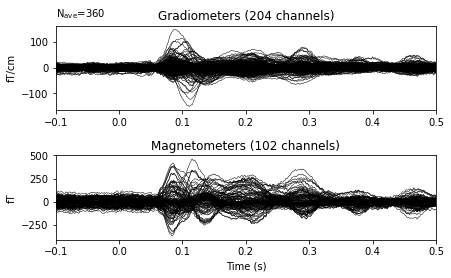

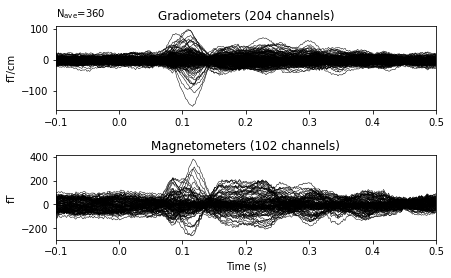

In [21]:
## looking at the data: 
epochs['face'].average().plot();
epochs['not-face'].average().plot();

## Downsampling

In [22]:
## downsample epochs from 1000 hz to 200 hz. 
epochs.resample(sfreq = 200, n_jobs = -1) #200 hz. 

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done 33808 tasks      | elapsed:    6.4s
[Parallel(n_jobs=8)]: Done 98320 tasks      | elapsed:   11.1s
[Parallel(n_jobs=8)]: Done 181264 tasks      | elapsed:   17.3s
[Parallel(n_jobs=8)]: Done 220320 out of 220320 | elapsed:   19.9s finished


<Epochs |  720 events (all good), -0.1 - 0.495 sec, baseline off, ~208.4 MB, data loaded,
 '0/human bodypart/human/not-face/animal/natural': 30
 '1/human bodypart/human/not-face/animal/natural': 30
 '10/human bodypart/human/not-face/animal/natural': 30
 '11/human bodypart/human/not-face/animal/natural': 30
 '12/human face/human/face/animal/natural': 30
 '13/human face/human/face/animal/natural': 30
 '14/human face/human/face/animal/natural': 30
 '15/human face/human/face/animal/natural': 30
 '16/human face/human/face/animal/natural': 30
 '17/human face/human/face/animal/natural': 30
 '18/human face/human/face/animal/natural': 30
 '19/human face/human/face/animal/natural': 30
 '2/human bodypart/human/not-face/animal/natural': 30
 '20/human face/human/face/animal/natural': 30
 '21/human face/human/face/animal/natural': 30
 '22/human face/human/face/animal/natural': 30
 '23/human face/human/face/animal/natural': 30
 '3/human bodypart/human/not-face/animal/natural': 30
 '4/human bodypart/h

## Creating results matrix

Has to have dimension 24 x 24 x number of time-points. <br/>
This is because we have 24 unique pictures that we want to predict. <br/>
This means that our results matrix will have all possible combinations <br/>
of those 24 pictures (x and y) and we have this for each time-point.

In [43]:
## creating results matrix (numpy array) of dimension 24x24xtime
results = np.zeros([24, 24, epochs.get_data().shape[-1]]) #or epochs.get_data().shape[-1]
results.shape

(24, 24, 120)

## Importing from sklearn 

Explanation in comments. 

In [24]:
from sklearn.model_selection import StratifiedKFold ## for cross-validation
from sklearn.pipeline import make_pipeline ## pipeline for 
from sklearn.preprocessing import StandardScaler ## scaling variables after train/test split. 
from sklearn.linear_model import LogisticRegression ## logistic regression is our ML-algorithm of choice. 
from sklearn.metrics import roc_auc_score ## I don't think we actually use this in the end..
from mne.decoding import SlidingEstimator, cross_val_multiscore ## sliding estimator wraps pipeline & cross-validation. 

## preparing the pipeline & model

First we make a pipeline which first scales the data and then applies logistic regression. 

In [26]:
clf = make_pipeline(StandardScaler(), # computed as: z = (x - u) / sd [x = value, u = mean, sd = standard deviation]
                      LogisticRegression()) ## using baseline settings. (l2-norm and C = 1)

time_decoder = SlidingEstimator(
    clf, #the pipeline. 
    n_jobs = -1, ## using all our cores.
    scoring='roc_auc') ## using area under the curve as our performance metric. 

cv = StratifiedKFold() #should have randomstate (but library.config issues) - do we even use this?

## Running everything 

What we want: <br/> 
We want to to train logistic regression on each unique combination of two pictures. <br/>
To use all of our data we do this by cross-validation. <br/>
This means that a lot of cross-validation runs will be run. <br/>
We get a score (roc-auc) for each cross-validation fold (we have 5). <br/>
We then take the mean of this score and put into the (initially empty) results <br/>
This has to be done for each time-point (what the time_decoder takes care of) <br/>
and - obviously - it has to be done for each (unique) combination of pictures. <br/>
Thus, it takes a lot of time. <br/>
I have already run this and saved the file as "results_4run.npy".

In [217]:
for ii in range(24): ## 24 pictures
    for jj in range(24): ## 24 pictures
        if ii > jj: ## Only do something if this is the case. Ensures only below diag. 
            cond_0 = ii ## define cond. 0 (int between 0-23)
            cond_1 = jj ## define cond. 1 (int. between 0-23)
            X = epochs[str(cond_0), str(cond_1)].get_data() ## taking X out. 
            y = epochs[str(cond_0), str(cond_1)].events[:, 2] ## trigger values (each diff cat)
            score = cross_val_multiscore(time_decoder, ## across all time-points. 
                                         X, ## train on two conditions (pictures)
                                         y, ## test on the same two conditions (pictures)
                                         cv = 5, ## five fold cross-validation
                                        n_jobs = -1) ## important: use all cores. 
            results[cond_0, cond_1] = score.mean(axis = 0) ## mean across folds axis and input to results array. 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    6.3s remaining:    9.4s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    9.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.8s remaining:    8.7s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    9.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.6s remaining:    8.4s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.6s remaining:    8.4s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    9.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.5s remaining:    8.3s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.8s remaining:    8.6s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.6s remaining:    8.4s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.7s remaining:    8.6s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    9.1s finished
[Parallel(n_jobs=4)]: Using ba

[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.4s remaining:    8.1s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.5s remaining:    8.2s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.7s remaining:    8.5s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.6s remaining:    8.4s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.5s remaining:    8.3s
[Parallel(n_jobs=4)]

[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.6s remaining:    8.5s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.5s remaining:    8.3s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.4s remaining:    8.1s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.5s remaining:    8.2s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.6s remaining:    8.4s
[Parallel(n_jobs=4)]

[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.6s remaining:    8.4s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.8s remaining:    8.7s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    9.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    6.0s remaining:    8.9s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.8s remaining:    8.6s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.8s remaining:    8.7s
[Parallel(n_jobs=4)]

[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.9s remaining:    8.8s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    9.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.6s remaining:    8.4s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.9s remaining:    8.9s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    9.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.6s remaining:    8.4s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.9s remaining:    8.9s
[Parallel(n_jobs=4)]

[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.6s remaining:    8.4s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    6.0s remaining:    8.9s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    9.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.7s remaining:    8.6s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    6.2s remaining:    9.2s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    9.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.8s remaining:    8.7s
[Parallel(n_jobs=4)]

[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.6s remaining:    8.3s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.4s remaining:    8.1s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.2s remaining:    7.9s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.5s remaining:    8.2s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.7s remaining:    8.6s
[Parallel(n_jobs=4)]

## Save the results for later

In [28]:
## np.save("results_4run.npy", results) ## save stuff. 
results = np.load("results_4run.npy")

## Plotting 1
First we would like to plot our average accuracy across time. <br/>
I.e., we will average over all the comparisons for each time-point. <br/> 
The output (run below) is not impressive. We only just manage to <br/>
get accuracy > 70% around 100 ms. after stimulus on-set.

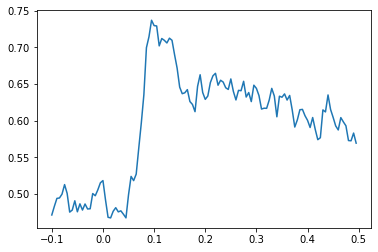

In [29]:
## accuracy across time: 
tri_idx = np.tril_indices(24, k=-1) #all different combinations of lower triangle. k-1 (no diag.)
plt.plot(epochs.times, results[tri_idx[0], tri_idx[1]].mean(axis = 0)) # mean over comparisons axis.

## Plotting 2

Now let us plot accuracy for some different time-points <br/>
without averaging the accuracies at pair-wise classification. <br/>
We will do: 
* -100 ms.
* 100 ms. 
* 300 ms. 
* 500 ms.
recall that sampling frequency is 200 hz. 

First we define time-points and time-labels and compute the corresponding images.


In [35]:
timePoints = [0, 40, 80, 119]
timeLabels = ["-100 ms", "100 ms", "300 ms", "500 ms"]
images = [results[:, :, x] for x in timePoints]

Then we define a function to nicely show these images. <br/>
This was inspired by some online code.

In [38]:
## function (half stolen from the internet): 
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    
    assert((titles is None) or (len(images) == len(titles)))
    
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
        
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        plt.imshow(image, cmap = 'viridis')
        plt.axline((11.5, 0), (11.5, 23), color = "black")
        plt.axline((0, 11.5), (23, 11.5), color = "black")
        plt.colorbar() 
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

Then we run the function on our images and labels. <br/>
We also specify cols = 2 to get a nice 2-by-2 grid presentation. <br/>
It is actually clear from the picture that accuracy is best around ~100-300 ms.

<ipython-input-38-0174263a7145>:23: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)


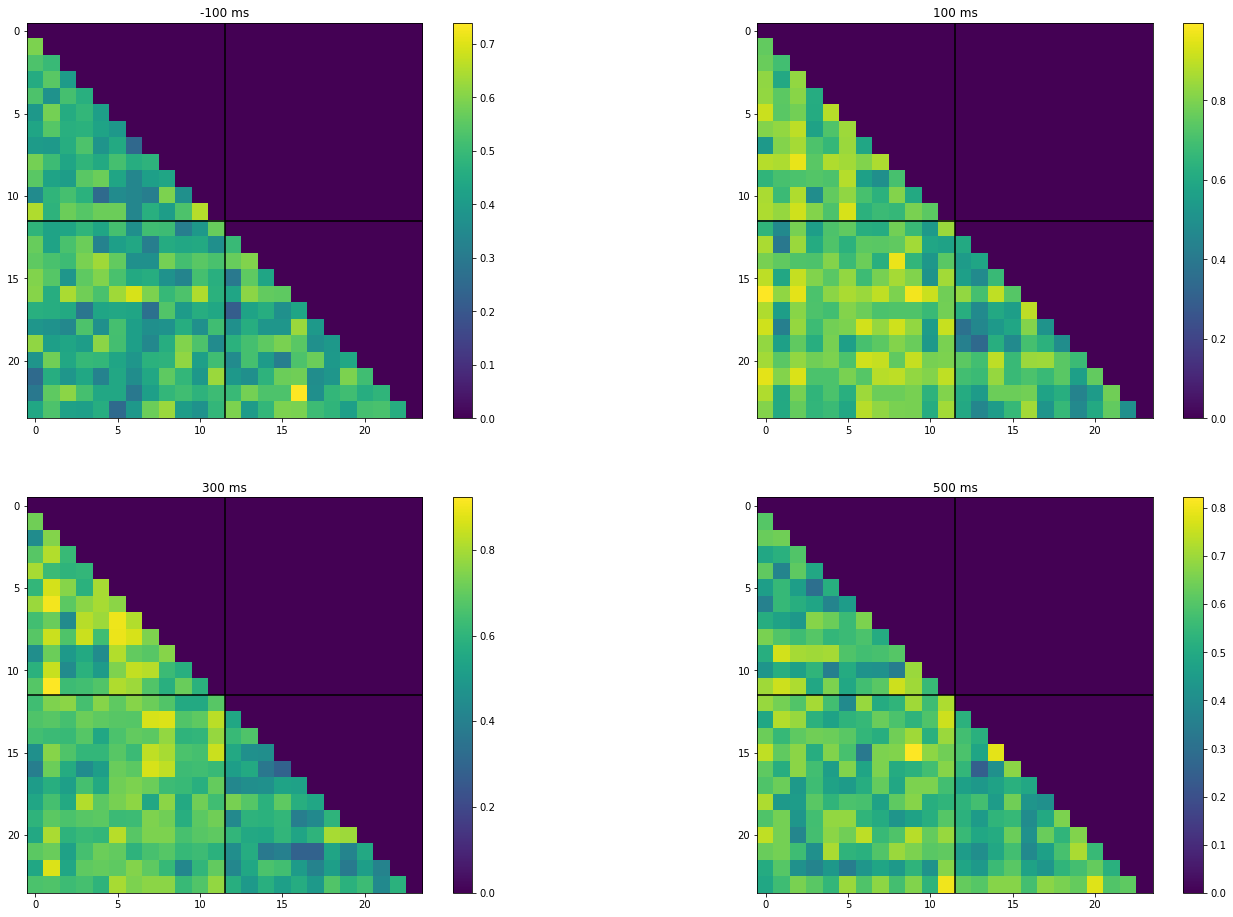

In [39]:
## running the function to generate plots: 
show_images(images = images, cols = 2, titles = timeLabels)

# plotting 3

Plotting accuracy per group over time.
groups selected: 
1. within not-face (should be hard - low accuracy)
2. within is-face (should be hard - low accuracy)
3. across condition (should be easiest - high accuracy)

In [40]:
epochs # 0-11 (not face), 12-23 (face)
not_face = results[0:12,0:12,:] #smaller triangular (upper left).
is_face = results[12:24, 12:24, :] #smaller triangular (lower right).
across = results[11:23, 0:12] #across conditions (lower left). 

In [41]:
tri_idx = np.tril_indices(12, k=-1) #can be used for (1) and (2)
square_idx = np.indices((12, 12)) #used for condition (3)

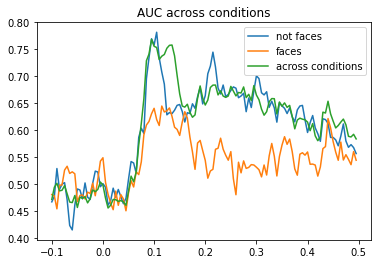

In [42]:
## plotting them: 
plt.plot(epochs.times, not_face[tri_idx[0], tri_idx[1]].mean(axis = 0),
        label = "not faces")
plt.plot(epochs.times, is_face[tri_idx[0], tri_idx[1]].mean(axis = 0),
        label = "faces")
plt.plot(epochs.times, across[square_idx[0].flatten(), square_idx[1].flatten()].mean(axis = 0),
        label = "across conditions")
plt.legend()
plt.title('AUC across conditions')
plt.show()


## Last comments

It appears that our classifier really learns to dissociate 

faces from non-faces (across conditions) and non-faces from non-faces

at around 100-150 ms. The effect then tapers off. 

Generally there is pretty low accuracy with a peak just above 75%

accuracy for both of the aforementioned clusters. 

Seems weird that it struggles with distinguishish

faces from faces throughout. Apparently these are more

similar than the non-faces (unless I have flipped stuff). 